In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
import matplotlib as mpl
from sklearn.model_selection import train_test_split
mpl.rcParams.update({'font.size': 15})

In [2]:
DATA = pd.read_excel('PTResults-1000.xlsx') # big dataset

param = DATA.iloc[:,1:6].to_numpy() # features
data = DATA.iloc[:, 6:].to_numpy()  # labels

nGroups = 10                   # number of groups
panels = DATA.iloc[4,6:].size # number of cells
nSamples = DATA.iloc[:,10].size
nK = 6                        # number of NN algorithms tried (NN1, NN3, NN5, NN7, NN9, NN11)
                              # the script trains one model for each


# building 10 groups
ids = np.arange(nSamples)
np.random.shuffle(ids)

cellsPerGroup = int(nSamples/nGroups)
groups = np.empty([nGroups,int(cellsPerGroup)],dtype=int)

for i in range(nGroups):
    groups[i,:] = ids[i*cellsPerGroup : i*cellsPerGroup+cellsPerGroup]


# variable to store the number of wrong predictions for each panel and each 
# NN algorithm (used to compute standard deviation)
str = np.empty([panels,nGroups,nK])


# accumulation variable for error on each panel
errPanel = np.empty([panels,nK])
for i in range(panels):
    for j in range(nK):
        errPanel[i,j] = 0

# initialization of the classifiers
NN1  = KNeighborsClassifier(n_neighbors=7)
NN3  = KNeighborsClassifier(n_neighbors=9)
NN5  = KNeighborsClassifier(n_neighbors=11)
NN7  = KNeighborsClassifier(n_neighbors=13)
NN9  = KNeighborsClassifier(n_neighbors=15)
NN11 = KNeighborsClassifier(n_neighbors=17)

labels = ['NN7','NN9','NN11','NN13','NN15','NN17']

counter = 0   # counts number of runs

# training models and computing errors w/ cross-validation. One group is used for testing 
# while the others are used for training. Repeat for all groups and average the error
for i in range(nGroups):
    
    counter = counter+1
    
    testIDs = groups[i,:]
    trainIDs = []

    for j in range(nGroups):
        if j != i:
            trainIDs.extend(groups[j,:])

    trainIDs = np.asarray(trainIDs, dtype=np.int)
            
    train_data = data[trainIDs,:]
    test_data  = data[testIDs,:]
    
    train_param = param[trainIDs,:]
    test_param  = param[testIDs,:]
    
    
    nTest  = test_data[:,1].size     # number of testing samples
    nTrain  = train_data[:,1].size     # number of training samples
    
    print("Run #",counter)
    
    # variable storing predicted labels for each NN algorithm
    pred = np.empty([nK,nTest,panels])

    # training a single classifier for all cells

    NN1.fit(train_param,train_data)
    pred[0,:,:] = NN1.predict(test_param)

    NN3.fit(train_param,train_data)
    pred[1,:,:] = NN3.predict(test_param)

    NN5.fit(train_param,train_data)
    pred[2,:,:] = NN5.predict(test_param)

    NN7.fit(train_param,train_data)
    pred[3,:,:] = NN7.predict(test_param)

    NN9.fit(train_param,train_data)
    pred[4,:,:] = NN9.predict(test_param)

    NN11.fit(train_param,train_data)
    pred[5,:,:] = NN11.predict(test_param)

    for i in range(nK):
        for p in range(panels):
            # storing (normalized) number of wrong predictions 
            str[p,counter-1,i] = (abs(pred[i,:,p] - test_data[:,p]).sum()  / nTest)
            # accumulating errors in variable errPanel
            errPanel[p,i] = errPanel[p,i] + (abs(pred[i,:,p] - test_data[:,p]).sum()  / nTest)

print("\n\n")

# print total number of miss classifications for each algorithm
totalMissClass = np.empty([nK])
for i in range(nK):
    totalMissClass[i] = str[:,:,i].sum() / (counter*panels) * 100
    print(labels[i]+' missclassified ',"%.3f" % totalMissClass[i],'% of the samples')


std = np.empty([panels,nK]) # standard deviation
for i in range(panels):
    if data[:,i].sum() == 0:
        errPanel[i,:] = 10
        std[i,:] = 0
    else:
        # computing error standard deviation at each panel
        for j in range(nK):
            std[i,j] = np.sqrt((1/counter)*((str[i,:,j]-errPanel[i,j]/counter)  * (str[i,:,j]-errPanel[i,j]/counter)).sum())

# error is plotted as %
errPanel = errPanel / counter * 100
std = std * 100

# reading header of xlsx file to get curvilinear cooridnates
CC = pd.read_excel('PTResults-1000.xlsx', header=None)
curv =  CC.iloc[0, 6:].to_numpy()
curv = np.array(curv,dtype=float) # matplotlib.pyplot.fill_between won't work w/o this line 

Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10



NN7 missclassified  5.419 % of the samples
NN9 missclassified  5.384 % of the samples
NN11 missclassified  5.289 % of the samples
NN13 missclassified  5.282 % of the samples
NN15 missclassified  5.220 % of the samples
NN17 missclassified  5.186 % of the samples


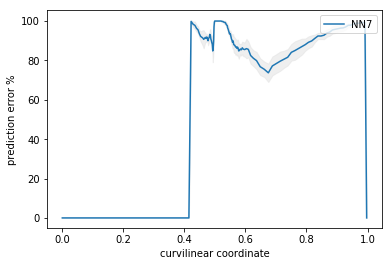

percentage of miss classifications at s = 0.61:  17.500
standard deviation:  4.177




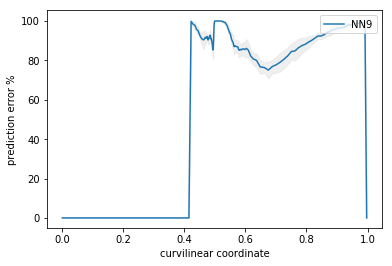

percentage of miss classifications at s = 0.61:  17.700
standard deviation:  3.002




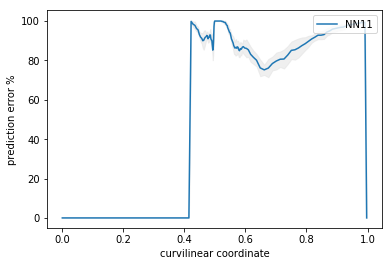

percentage of miss classifications at s = 0.61:  16.900
standard deviation:  3.859




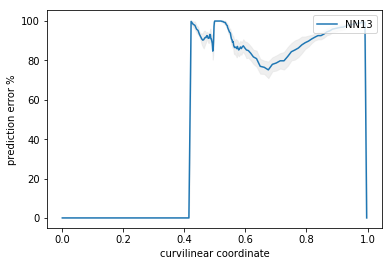

percentage of miss classifications at s = 0.61:  16.300
standard deviation:  3.579




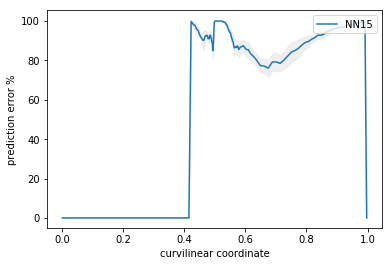

percentage of miss classifications at s = 0.61:  16.600
standard deviation:  3.527




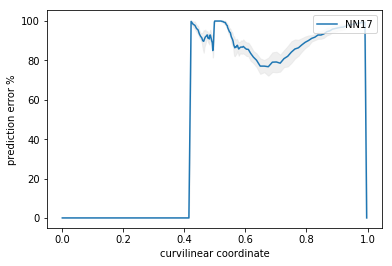

percentage of miss classifications at s = 0.61:  16.400
standard deviation:  3.774




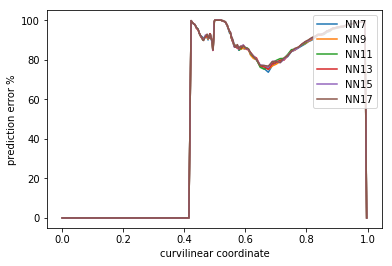

In [3]:
# plotting one figure for each NN algorithm
# x axis curvilinear coordinates
# y axis percentage of missed predictions averaged on all runs. Shaded area is standard deviation
# figure on the right shows histogramm at s = 0.6170...
target = 136 # s = 0.6170...

cs     = ['r','b','y','g','k','c']

# plt.rc('font',**{'family':'serif','serif':['Palatino']})
# plt.rc('text', usetex=True)

for i in range(nK):

#     fig, axes = plt.subplots(1,1,gridspec_kw={'width_ratios': [5, 2]},figsize=(9,4))
#     axes[0].plot(curv,errPanel[:,i],label=labels[i])  # error
#     axes[0].fill_between(curv, errPanel[:,i]-std[:,i], errPanel[:,i]+std[:,i],  # fills area according to standard deviation
#         alpha=0.5,color='#e0e0e0')
#     axes[0].legend(loc='upper right')
#     axes[0].set_xlabel('curvilinear coordinate')
#     axes[0].set_ylabel('prediction error %')
#     axes[1].hist(str[target,:,i], bins=12)
#     axes[1].set_xlabel('missed classifications')
#     plt.savefig('plots_nD/'+labels[i]+'.eps', format='eps')
    plt.figure()
    plt.plot(curv,100-errPanel[:,i],label=labels[i])  # error
    plt.fill_between(curv, 100-errPanel[:,i]-std[:,i], 100-errPanel[:,i]+std[:,i],  # fills area according to standard deviation
        alpha=0.5,color='#e0e0e0')
    plt.legend(loc='upper right')
    plt.xlabel('curvilinear coordinate')
    plt.ylabel('precision %')
#     plt.savefig('kNN_c/'+labels[i]+'.eps', format='eps')
    plt.show()
    print('percentage of miss classifications at s = 0.61: ',"%.3f" % errPanel[target,i])
    print('standard deviation: ',"%.3f" % std[target,i])
    print('\n')


# plots single figure comparing all NN algo
plt.figure()
for i in range(nK):
    plt.plot(curv,100-errPanel[:,i],label=labels[i])

plt.legend(loc='upper right')
plt.xlabel('curvilinear coordinate')
plt.ylabel('precision %')
# plt.savefig('kNN_c/NN_comp.eps', format='eps')
plt.show()

In [4]:
# from sklearn.model_selection import cross_val_score
# recall_3 = cross_val_score(NN1, param, data[:,140], cv=10, scoring='recall')
# print(recall_3)